<a href="https://colab.research.google.com/github/LucasThierry/Neural-Networks-21.1/blob/main/MiniProjeto3-LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MiniProjeto 3 - LSTM - Redes Neurais 


## Empregar LSTM para prever o preço do Bitcoin de dezembro de 2014 a maio de 2018

### **Grupo: Josenildo Vicente de Araújo (jva@cin.ufpe.br), Lucas Thierry Chaves Muniz (ltcm@cin.ufpe.br), Nicholas Henrique Justino Ferreira (nhjf@cin.ufpe.br), Renato Joaquim Miranda Ferreira (rjmf@cin.ufpe.br)**

O seguinte MiniProjeto tem como objetivo praticar os conceitos e teorias aprendidas na disciplina de Redes Neurais a respeito do funcionamento do modelo de LSTM para predição do preço do bitcoin numa determinada janela temporal. De maneira a variar os parâmetros do modelo treinado e observar seus resultados, a rede utilizada em questão, tem como função fazer a predição do preço da moeda aprendendo a partir do valores informados dataset disponibilizado passando diversos atributos da moeda no dia corrente, como o valor inicial que ela foi comercializada no dia em questão, qual o valor mais alto atingido no dia, o valor mais baixo do dia e em qual valor ela foi fechada bem como seu volume inicial e final. A partir dessas informações a rede tentará prever em qual valor o bitcoin será fechado para o dado instante de tempo.

Começamos pela importação do pacote das bibliotecas do tensorflow,pandas e numpu para construção do modelo, importação do dataset. O matplotlib será a biblioteca gráfica e será usada quando for pertinente

In [27]:
#importing the libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import io
%matplotlib inline

In [28]:
df = pd.read_csv('https://raw.githubusercontent.com/brynmwangy/predicting-bitcoin-prices-using-LSTM/master/btc.csv',encoding='ISO-8859-1')
df.head()

,Date,Symbol,Open,High,Low,Close,Volume From,Volume To
0,5/26/2018,BTCUSD,7459.1100,7640.4600,7380.0000,7520.0000,2722.8000,20422651.8100
1,5/25/2018,BTCUSD,7584.1500,7661.8500,7326.9400,7459.1100,8491.9300,63420692.8200
2,5/24/2018,BTCUSD,7505.0000,7734.9900,7269.0000,7584.1500,11033.7200,82931373.7600
3,5/23/2018,BTCUSD,7987.7000,8030.0000,7433.1900,7505.0000,14905.9900,114810431.5000
4,5/22/2018,BTCUSD,8393.4400,8400.0000,7950.0000,7987.7000,6589.4300,53897527.4800


Nesse ponto selecionamos apenas a coluna do dataset relativa ao preço de fechamento da moeda para predição de seu valor

In [29]:
#selecting only the column that we are going to use in the prediction process
data_to_use=df['Close'].values
data_to_use = data_to_use[::-1]
data_to_use

array([ 370.  ,  378.  ,  378.  , ..., 7584.15, 7459.11, 7520.  ])

Com o novo dataset em mãos, é feito o uso do StandardScaler para normalizar o dataset e seguir com as análises

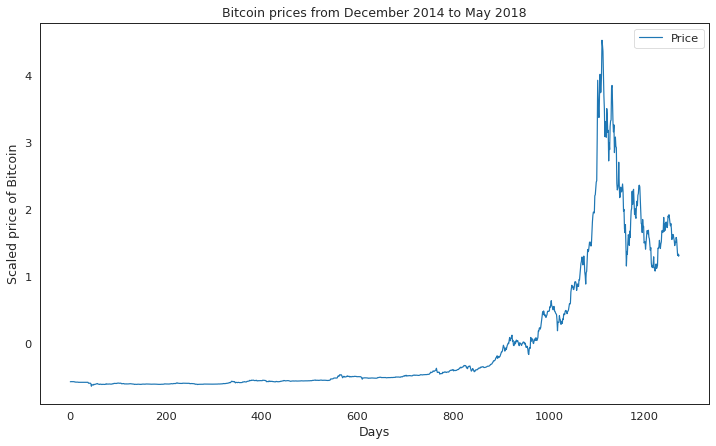

In [30]:
#data preprocessing(scaling)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_use.reshape(-1, 1))
#plotting the data
import matplotlib.pyplot as plt
plt.figure(figsize=(12,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Bitcoin prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled price of Bitcoin')
plt.plot(scaled_data, label='Price')
plt.legend()
plt.show()

É separado o dataset na proporção de 80% para o conjunto de treinamento e 20% para o conjunto de testes bem como seleção das labels e features de acordo com o tamanho da janela escolhida, por exemplo, caso o window_size = 1 então tentará ser previsto o valor de hoje usando apenas a informação do dia anterior

In [31]:
# This function is used to create Features and Labels datasets. By windowing the data.
#Input: data - dataset used in the project
#window_size - how many data points we are going to use to predict the next datapoint in the sequence 
#[Example: if window_size = 1 we are going to use only the previous day to predict todays stock prices]
#Outputs: X - features splitted into windows of datapoints (if window_size = 1, X = [len(data)-1, 1])
#y - 'labels', actually this is the next number in the sequence, this number we are trying to predict

def window_data(data, window_size):
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i += 1
    assert len(X) ==  len(y)
    return X, y
#windowing the data with window_data function
X, y = window_data(scaled_data, 7)


#we now split the data into training and test set
import numpy as np
X_train  = np.array(X[:1018])
y_train = np.array(y[:1018])

X_test = np.array(X[1018:])
y_test = np.array(y[1018:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (1018, 7, 1)
y_train size: (1018, 1)
X_test size: (248, 7, 1)
y_test size: (248, 1)


Nesse ponto será contruído o modelo do LSTM no qual passamos os parâmetros como o batch_size, hidden_layer, window_size, clip_margin,learning_rate e epochs para o treinamento e construção do modelo, primariamente o otimizador utilizado será o Adam fornecido pelo tensorflow

In [66]:
import tensorflow as tf
#function to compute the gate states
def LSTM_cell(input, output, state, weights_input_gate,weights_input_hidden,bias_input,bias_forget,bias_output,bias_memory_cell
              ,weights_memory_cell,weights_forget_gate,weights_forget_hidden,weights_output_gate,weights_output_hidden,weights_memory_cell_hidden):
    
    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)
    
    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)
    
    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)
    
    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)
    
    state = state * forget_gate + input_gate * memory_cell
    
    output = output_gate * tf.tanh(state)
    return state, output


def lstm(params):
  batch_size = params['batch_size']
  hidden_layer = params['hidden_layer']
  window_size = params['window_size']
  clip_margin = params['clip_margin']
  learning_rate = params['learning_rate']
  epochs = params['epochs']

  #we define the placeholders
  inputs = tf.compat.v1.placeholder(tf.float32, [batch_size, window_size, 1])
  targets = tf.compat.v1.placeholder(tf.float32, [batch_size, 1])



  #weights and implementation of LSTM cell
  # LSTM weights

  #Weights for the input gate
  weights_input_gate = tf.Variable(tf.random.truncated_normal([1, hidden_layer], stddev=0.05))
  weights_input_hidden = tf.Variable(tf.random.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
  bias_input = tf.Variable(tf.zeros([hidden_layer]))

  #weights for the forgot gate
  weights_forget_gate = tf.Variable(tf.random.truncated_normal([1, hidden_layer], stddev=0.05))
  weights_forget_hidden = tf.Variable(tf.random.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
  bias_forget = tf.Variable(tf.zeros([hidden_layer]))

  #weights for the output gate
  weights_output_gate = tf.Variable(tf.random.truncated_normal([1, hidden_layer], stddev=0.05))
  weights_output_hidden = tf.Variable(tf.random.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
  bias_output = tf.Variable(tf.zeros([hidden_layer]))

  #weights for the memory cell
  weights_memory_cell = tf.Variable(tf.random.truncated_normal([1, hidden_layer], stddev=0.05))
  weights_memory_cell_hidden = tf.Variable(tf.random.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
  bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

  #Output layer weigts
  weights_output = tf.Variable(tf.random.truncated_normal([hidden_layer, 1], stddev=0.05))
  bias_output_layer = tf.Variable(tf.zeros([1]))



  #we now define loop for the network
  outputs = []
  for i in range(batch_size): #Iterates through every window in the batch
    
      #for each batch I am creating batch_state as all zeros and output for that window which is all zeros at the beginning as well.
      batch_state = np.zeros([1, hidden_layer], dtype=np.float32) 
      batch_output = np.zeros([1, hidden_layer], dtype=np.float32)
      
      #for each point in the window we are feeding that into LSTM to get next output
      for ii in range(window_size):
          batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output,  weights_input_gate,weights_input_hidden,bias_input,bias_forget,bias_output,bias_memory_cell
              ,weights_memory_cell,weights_forget_gate,weights_forget_hidden,weights_output_gate,weights_output_hidden,weights_memory_cell_hidden)
          
      #last output is conisdered and used to get a prediction
      outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)
  #we define the loss
  losses = []

  for i in range(len(outputs)):
      losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))
      
  loss = tf.reduce_mean(losses)

  #we define optimizer with gradient clipping
  gradients = tf.gradients(loss, tf.compat.v1.trainable_variables())
  clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
  optimizer = tf.optimizers.Adam(learning_rate)
  trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.compat.v1.trainable_variables()))

  #we now train the network
  session = tf.compat.v1.Session()
  session.run(tf.compat.v1.global_variables_initializer())
  for i in range(epochs):
      traind_scores = []
      ii = 0
      epoch_loss = []
      while(ii + batch_size) <= len(X_train):
          X_batch = X_train[ii:ii+batch_size]
          y_batch = y_train[ii:ii+batch_size]
          
          o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})
          
          epoch_loss.append(c)
          traind_scores.append(o)
          ii += batch_size
      if (i % 10) == 0:
        losss.append(np.mean(epoch_loss))
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

  for i in range(len(traind_scores)):
    for j in range(len(traind_scores[i])):
        sup.append(traind_scores[i][j][0])

  i = 0
  while i+batch_size <= len(X_test): 
    
      o = session.run([outputs],feed_dict={inputs:X_test[i:i+batch_size]})
      i += batch_size
      tests.append(o)

  for i in range(len(tests)):
    for j in range(len(tests[i][0])):
      tests_new.append(tests[i][0][j])

  for i in range(1264):
    if i >= 1019:
      test_results.append(tests_new[i-1019])
    else:
      test_results.append(None)


Após construção do modelo, vamos finalmente aos testes, para esse teste escolhemos os valores 'padrões' do modelo para verificar o quão bem essa primeira versão de testes será

## Versão Original


In [33]:
from time import time
sup = []
tests = []
tests_new = []
test_results = []
losss = []
params = {'batch_size': 7, #how many windows of data we are passing at once
'window_size': 7, #how big window_size is (Or How many days do we consider to predict next point in the sequence)
'hidden_layer': 256, #How many units do we use in LSTM cell
'clip_margin': 4, #To prevent exploding gradient, we use clipper to clip gradients below -margin or above this margin
'learning_rate' : 0.001 ,
'epochs' : 200 }

t_now = time()
tf.compat.v1.disable_eager_execution()
lstm(params)
duration = time() - t_now
print("duration time: %0.3fs" % duration)

results_v1 = test_results

Epoch 0/200  Current loss: 0.019769711419939995
Epoch 10/200  Current loss: 0.04899527505040169
Epoch 20/200  Current loss: 0.0014866177225485444
Epoch 30/200  Current loss: 0.0011274792486801744
Epoch 40/200  Current loss: 0.0016601819079369307
Epoch 50/200  Current loss: 0.0013227068120613694
Epoch 60/200  Current loss: 0.002704446902498603
Epoch 70/200  Current loss: 0.0005320834461599588
Epoch 80/200  Current loss: 0.0004891785210929811
Epoch 90/200  Current loss: 0.0005289239343255758
Epoch 100/200  Current loss: 0.0005255098221823573
Epoch 110/200  Current loss: 0.0004585969145409763
Epoch 120/200  Current loss: 0.0009025937761180103
Epoch 130/200  Current loss: 0.0008250037208199501
Epoch 140/200  Current loss: 0.0008851711172610521
Epoch 150/200  Current loss: 0.0008686495129950345
Epoch 160/200  Current loss: 0.0008259807946160436
Epoch 170/200  Current loss: 0.0004615679499693215
Epoch 180/200  Current loss: 0.00043029466178268194
Epoch 190/200  Current loss: 0.00044018615153

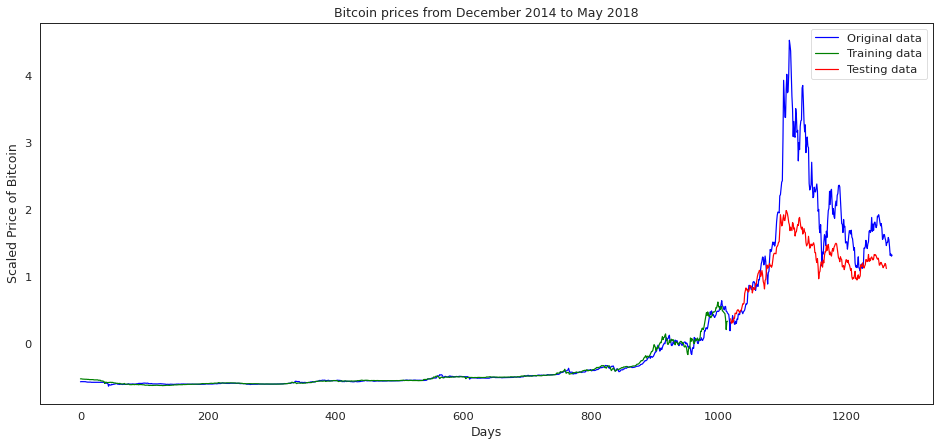

In [34]:
#we now plot predictions from the network
plt.figure(figsize=(16, 7))
plt.title('Bitcoin prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled Price of Bitcoin')
plt.plot(scaled_data, label='Original data',color='blue')
plt.plot(sup, label='Training data',color='green')
plt.plot(test_results, label='Testing data',color='red')
plt.legend()
plt.show()

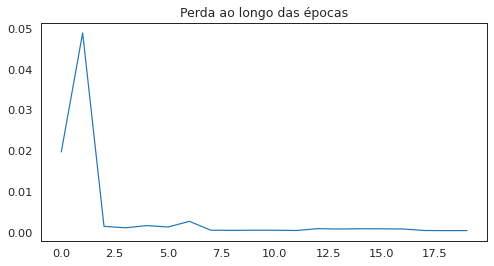

In [35]:
plt.figure(figsize=(8, 4))
plt.title('Perda ao longo das épocas')
plt.plot(losss)

Como é possível observar, nosso modelo está bem próximo do valor de fechamento real do dataset real, porém chegando aos anos mais recentes apesar do 'desenho' da curva ser semelhante, os valores encontrados pelo conjunto de testes ainda se encontram bem distantes do real. 

Além disso é possível observar a melhor na loss do treinamento, começando com uma loss 'bem alta' e estabilizando proximo de 0 com tempo de execução em torno de 13 minutos

Como ainda não construímos um modelo bom o suficiente, vamos criar uma nova versão com window size = 3, ou seja, olharemos 3 dias anteriores e batch size = 7

## Versão 2.0

In [36]:
X, y = window_data(scaled_data, 3)


#we now split the data into training and test set
X_train  = np.array(X[:1018])
y_train = np.array(y[:1018])

X_test = np.array(X[1018:])
y_test = np.array(y[1018:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

sup = []
tests = []
tests_new = []
test_results = []
losss = []

params = {'batch_size': 7, #how many windows of data we are passing at once
'window_size': 3, #how big window_size is (Or How many days do we consider to predict next point in the sequence)
'hidden_layer': 256, #How many units do we use in LSTM cell
'clip_margin': 4, #To prevent exploding gradient, we use clipper to clip gradients below -margin or above this margin
'learning_rate' : 0.001 ,
'epochs' : 200 }

t_now = time()
lstm(params)
duration = time() - t_now
print("duration time: %0.3fs" % duration)

results_v2 = test_results

X_train size: (1018, 3, 1)
y_train size: (1018, 1)
X_test size: (252, 3, 1)
y_test size: (252, 1)
Epoch 0/200  Current loss: 0.02530532516539097
Epoch 10/200  Current loss: 0.003884226316586137
Epoch 20/200  Current loss: 0.005155509803444147
Epoch 30/200  Current loss: 0.003305012360215187
Epoch 40/200  Current loss: 0.001475959550589323
Epoch 50/200  Current loss: 0.0016933368751779199
Epoch 60/200  Current loss: 0.0016555791953578591
Epoch 70/200  Current loss: 0.0015168612590059638
Epoch 80/200  Current loss: 0.0013887732056900859
Epoch 90/200  Current loss: 0.0012393196811899543
Epoch 100/200  Current loss: 0.0010725697502493858
Epoch 110/200  Current loss: 0.001012030290439725
Epoch 120/200  Current loss: 0.0012848565820604563
Epoch 130/200  Current loss: 0.0017655292758718133
Epoch 140/200  Current loss: 0.0015942526515573263
Epoch 150/200  Current loss: 0.0013078870251774788
Epoch 160/200  Current loss: 0.0011899705277755857
Epoch 170/200  Current loss: 0.001328152371570468
Epo

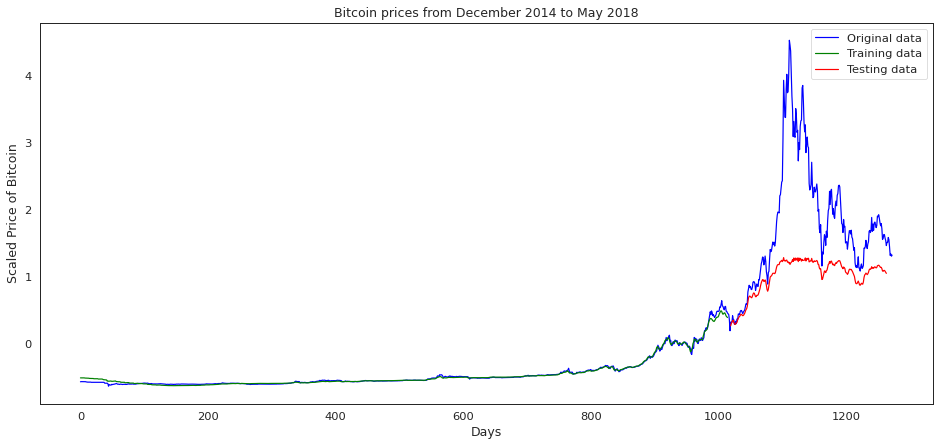

In [37]:
#we now plot predictions from the network
plt.figure(figsize=(16, 7))
plt.title('Bitcoin prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled Price of Bitcoin')
plt.plot(scaled_data, label='Original data',color='blue')
plt.plot(sup, label='Training data',color='green')
plt.plot(test_results, label='Testing data',color='red')
plt.legend()
plt.show()

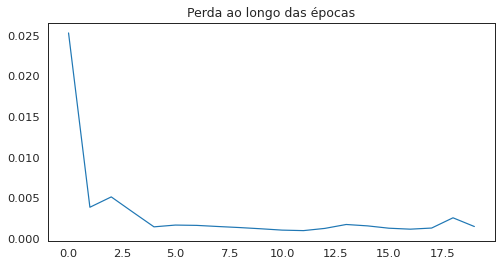

In [38]:
plt.figure(figsize=(8, 4))
plt.title('Perda ao longo das épocas')
plt.plot(losss)

Como é possível perceber, mesmo com uma loss baixa o modelo não se saiu muito bem com o conjunto de testes com window_size=3 e batch_size = 7, passando longe do preço real do bitcoin mesmo com seu tempo de execução menor, de aproximadamente 5 minutos

Para essa versão do modelo olharemos para 10 dias anteriores com batch_size = 7

## Versão 3.0

In [39]:
X, y = window_data(scaled_data, 10)


#we now split the data into training and test set
X_train  = np.array(X[:1018])
y_train = np.array(y[:1018])

X_test = np.array(X[1018:])
y_test = np.array(y[1018:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

sup = []
tests = []
tests_new = []
test_results = []
losss = []

params = {'batch_size': 7, #how many windows of data we are passing at once
'window_size': 10, #how big window_size is (Or How many days do we consider to predict next point in the sequence)
'hidden_layer': 256, #How many units do we use in LSTM cell
'clip_margin': 4, #To prevent exploding gradient, we use clipper to clip gradients below -margin or above this margin
'learning_rate' : 0.001 ,
'epochs' : 200 }

t_now = time()
lstm(params)
duration = time() - t_now
print("duration time: %0.3fs" % duration)

results_v3 = test_results

X_train size: (1018, 10, 1)
y_train size: (1018, 1)
X_test size: (245, 10, 1)
y_test size: (245, 1)
Epoch 0/200  Current loss: 0.019624212756752968
Epoch 10/200  Current loss: 0.0034674631897360086
Epoch 20/200  Current loss: 0.00038220020360313356
Epoch 30/200  Current loss: 0.0007635263609699905
Epoch 40/200  Current loss: 0.0007553527830168605
Epoch 50/200  Current loss: 0.0006587059469893575
Epoch 60/200  Current loss: 0.00037436181446537375
Epoch 70/200  Current loss: 0.0003014828253071755
Epoch 80/200  Current loss: 0.00040561918285675347
Epoch 90/200  Current loss: 0.0003228707064408809
Epoch 100/200  Current loss: 0.0003143349604215473
Epoch 110/200  Current loss: 0.00040518882451578975
Epoch 120/200  Current loss: 0.0005771211581304669
Epoch 130/200  Current loss: 0.0006072365213185549
Epoch 140/200  Current loss: 0.0004476690082810819
Epoch 150/200  Current loss: 0.0007377903093583882
Epoch 160/200  Current loss: 0.0003954509156756103
Epoch 170/200  Current loss: 0.0004901664

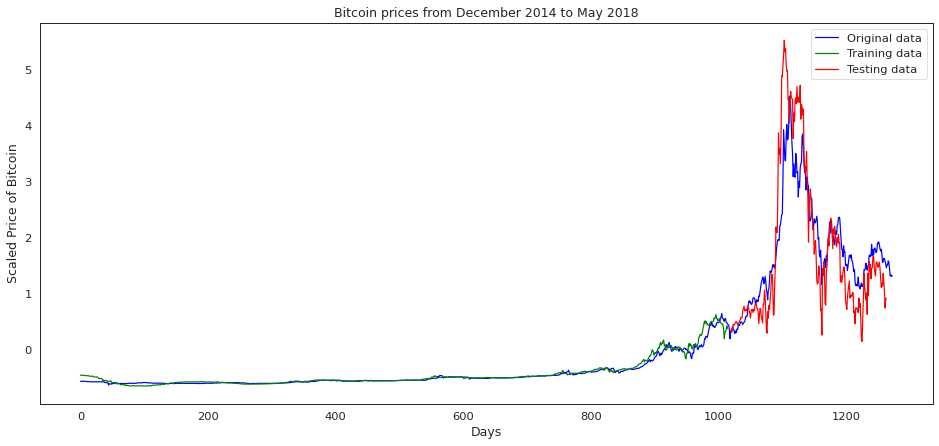

In [40]:
#we now plot predictions from the network
plt.figure(figsize=(16, 7))
plt.title('Bitcoin prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled Price of Bitcoin')
plt.plot(scaled_data, label='Original data',color='blue')
plt.plot(sup, label='Training data',color='green')
plt.plot(test_results, label='Testing data',color='red')
plt.legend()
plt.show()

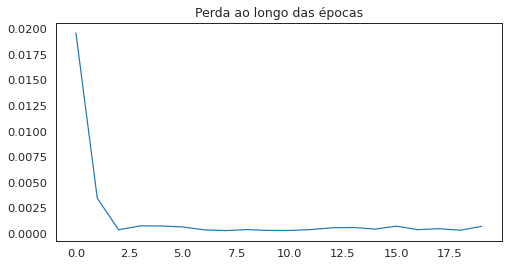

In [41]:
plt.figure(figsize=(8, 4))
plt.title('Perda ao longo das épocas')
plt.plot(losss)

Como é possível observar, apesar de que em alguns momento a 3;0 versão do modelo ter exagerado os valores finais, a 3 versão se mostrou a versão mais promissora tanto em termos de gráfico de tendência quanto em loss rodando em cerca de 20 minutos.

Para essa versão do modelo olharemos para 5 dias anteriores com batch_size = 5

## Versão 4.0

In [67]:
X, y = window_data(scaled_data, 5)


#we now split the data into training and test set
X_train  = np.array(X[:1018])
y_train = np.array(y[:1018])

X_test = np.array(X[1018:])
y_test = np.array(y[1018:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

sup = []
tests = []
tests_new = []
test_results = []
losss = []

params = {'batch_size': 5, #how many windows of data we are passing at once
'window_size': 5, #how big window_size is (Or How many days do we consider to predict next point in the sequence)
'hidden_layer': 256, #How many units do we use in LSTM cell
'clip_margin': 4, #To prevent exploding gradient, we use clipper to clip gradients below -margin or above this margin
'learning_rate' : 0.001 ,
'epochs' : 200 }

t_now = time()
lstm(params)
duration = time() - t_now
print("duration time: %0.3fs" % duration)

results_v4 = test_results

X_train size: (1018, 5, 1)
y_train size: (1018, 1)
X_test size: (250, 5, 1)
y_test size: (250, 1)
Epoch 0/200  Current loss: 0.01438047643750906
Epoch 10/200  Current loss: 0.0013387150829657912
Epoch 20/200  Current loss: 0.0009123584604822099
Epoch 30/200  Current loss: 0.0005932673229835927
Epoch 40/200  Current loss: 0.00044911939767189324
Epoch 50/200  Current loss: 0.00044873839942738414
Epoch 60/200  Current loss: 0.0005394462496042252
Epoch 70/200  Current loss: 0.0015511879464611411
Epoch 80/200  Current loss: 0.0017259009182453156
Epoch 90/200  Current loss: 0.0010654325596988201
Epoch 100/200  Current loss: 0.0007561941165477037
Epoch 110/200  Current loss: 0.0006358540267683566
Epoch 120/200  Current loss: 0.0005881005781702697
Epoch 130/200  Current loss: 0.0005856127245351672
Epoch 140/200  Current loss: 0.00050847337115556
Epoch 150/200  Current loss: 0.0004607875889632851
Epoch 160/200  Current loss: 0.0004707933694589883
Epoch 170/200  Current loss: 0.00039163249311968

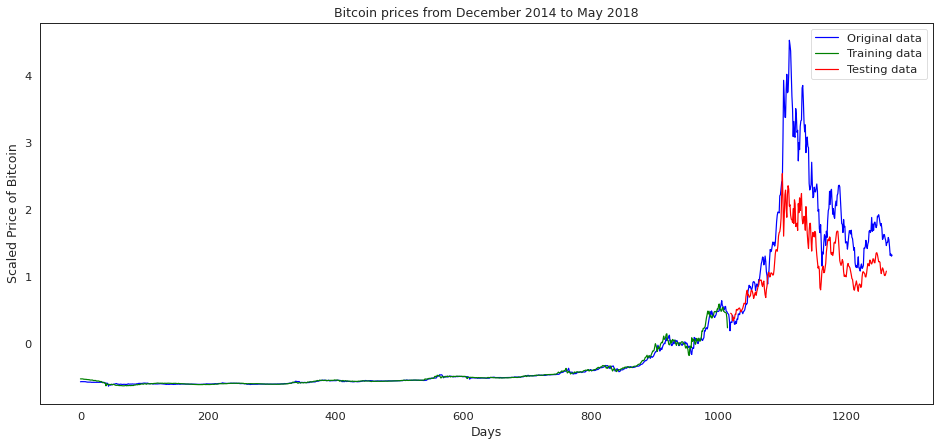

In [69]:
#we now plot predictions from the network
plt.figure(figsize=(16, 7))
plt.title('Bitcoin prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled Price of Bitcoin')
plt.plot(scaled_data, label='Original data',color='blue')
plt.plot(sup, label='Training data',color='green')
plt.plot(test_results, label='Testing data',color='red')
plt.legend()
plt.show()

Apesar do valor encontrado pelo teste estar abaixo do valor real do bitcoin, o modelo possui um gráfico muito semelhante ao gráfico real da moeda durante o período real porém ainda inferior a versão 3.0. Para esse modelo foi utilizado window_size = 5 e batch_size = 5 com um tempo de execução de 10 minutos

## Versão 5.0

In [76]:
X, y = window_data(scaled_data, 10)


#we now split the data into training and test set
X_train  = np.array(X[:1018])
y_train = np.array(y[:1018])

X_test = np.array(X[1018:])
y_test = np.array(y[1018:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

sup = []
tests = []
tests_new = []
test_results = []
losss = []

params = {'batch_size': 7, #how many windows of data we are passing at once
'window_size': 10, #how big window_size is (Or How many days do we consider to predict next point in the sequence)
'hidden_layer': 256, #How many units do we use in LSTM cell
'clip_margin': 4, #To prevent exploding gradient, we use clipper to clip gradients below -margin or above this margin
'learning_rate' : 0.0001 ,
'epochs' : 200 }

t_now = time()
lstm(params)
duration = time() - t_now
print("duration time: %0.3fs" % duration)

results_v5 = test_results

X_train size: (1018, 10, 1)
y_train size: (1018, 1)
X_test size: (245, 10, 1)
y_test size: (245, 1)
Epoch 0/200  Current loss: 0.09508481621742249
Epoch 10/200  Current loss: 0.0011720963520929217
Epoch 20/200  Current loss: 0.0010929835261777043
Epoch 30/200  Current loss: 0.0009600555058568716
Epoch 40/200  Current loss: 0.0012221074430271983
Epoch 50/200  Current loss: 0.0020225991029292345
Epoch 60/200  Current loss: 0.004154409747570753
Epoch 70/200  Current loss: 0.0017219081055372953
Epoch 80/200  Current loss: 0.0035014201421290636
Epoch 90/200  Current loss: 0.001495842938311398
Epoch 100/200  Current loss: 0.0038567427545785904
Epoch 110/200  Current loss: 0.0015624722000211477
Epoch 120/200  Current loss: 0.0009382869466207922
Epoch 130/200  Current loss: 0.001582473749294877
Epoch 140/200  Current loss: 0.00044427296961657703
Epoch 150/200  Current loss: 0.0011862879619002342
Epoch 160/200  Current loss: 0.0006412100628949702
Epoch 170/200  Current loss: 0.00063045177375897

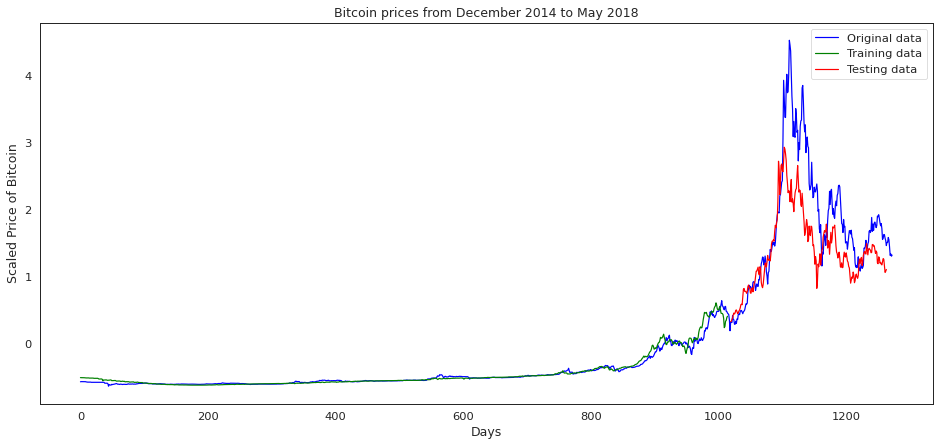

In [77]:
#we now plot predictions from the network
plt.figure(figsize=(16, 7))
plt.title('Bitcoin prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled Price of Bitcoin')
plt.plot(scaled_data, label='Original data',color='blue')
plt.plot(sup, label='Training data',color='green')
plt.plot(test_results, label='Testing data',color='red')
plt.legend()
plt.show()

Utilizando os parâmetros da versão 3.0 do modelo com um learning rate menor, de 0,001 para 0,0001, o gráfico se torna ainda mais semelhante ao valor esperado pelo dataset real porém ainda inferior a versão 3.0

## Comparando as versões

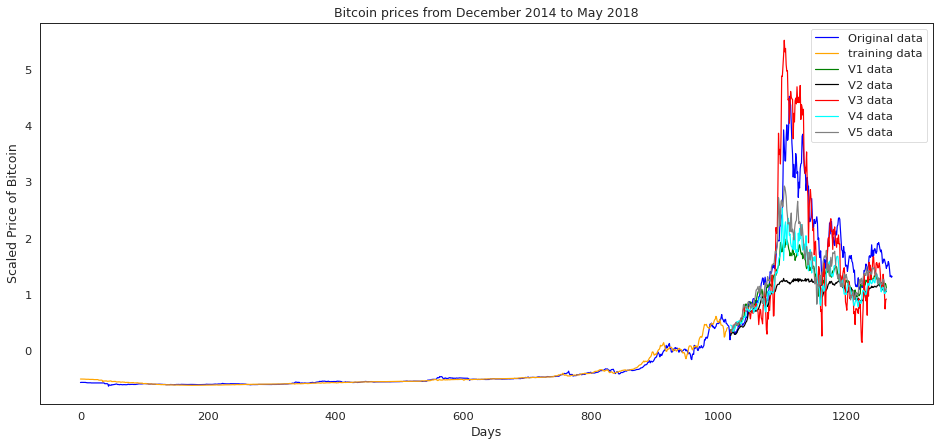

In [79]:
#we now plot predictions from the network
plt.figure(figsize=(16,7))
plt.title('Bitcoin prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled Price of Bitcoin')
plt.plot(scaled_data, label='Original data',color='blue')
plt.plot(sup, label='training data',color='orange')
plt.plot(results_v1, label='V1 data',color='green')
plt.plot(results_v2, label='V2 data',color='black')
plt.plot(results_v3, label='V3 data',color='red')
plt.plot(results_v4, label='V4 data',color='cyan')
plt.plot(results_v5, label='V5 data',color='gray')
plt.legend()
plt.show()

## Conclusão

O melhor modelo construído pelo LSTM construído foi o modelo disponível na versão 3.0 apesar de ter exagerado os valores finais, se mostrou a versão mais promissora tanto em termos de gráfico de tendência quanto em loss, fato esse evidenciado ao gráfico de comparação acima.